## Costruzione Modello Base SARIMAX con Selezione Automatica

In questo script viene costruito il modello base per la serie NIC_destag_ISTAT_diff1, che include una dummy per la rottura strutturale. Per trovare la migliore combinazione possibile degli ordini (p,q,P,Q) per il modello, si sfrutta l'approccio di ricerca automatica degli ordini (grid search) per modelli SARIMA(X).

>>> INIZIO SCRIPT FASE 6: Costruzione Modello Base SARIMAX (Selezione Automatica v3) <<<

Directory di output: '/Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli'

--- Caricamento Serie Stazionarie da: /Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2/indici_gt_nic_stazionari_fase2.csv ---
Serie caricate con successo. Shape: (252, 3)
--- Analisi ACF/PACF per: NIC_destag_ISTAT_diff1 (per guida visuale) ---


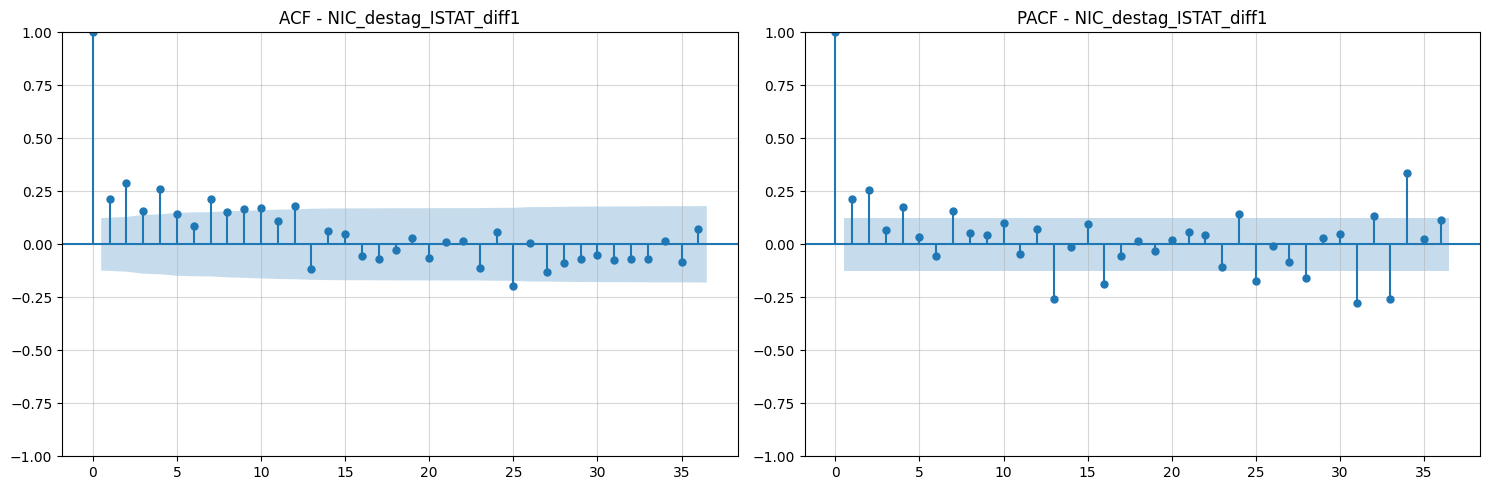


=== INIZIO RICERCA AUTOMATICA ORDINI SARIMA (Criterio: AIC) ===
Range ordini: p<=2, q<=2, P<=1, Q<=1 | d=0, D=0, s=12
Numero totale di combinazioni da testare: 36
Test modello 1/36: SARIMA(0, 0, 0)(0, 0, 0, 12)...
Test modello 11/36: SARIMA(0, 0, 2)(1, 0, 0, 12)...
Test modello 21/36: SARIMA(1, 0, 2)(0, 0, 0, 12)...
Test modello 31/36: SARIMA(2, 0, 1)(1, 0, 0, 12)...
Test modello 36/36: SARIMA(2, 0, 2)(1, 0, 1, 12)...

=== MIGLIOR MODELLO TROVATO (secondo AIC e Ljung-Box) ===
Ordini: SARIMA(1, 0, 1)(0, 0, 0, 12)
AIC: 221.879, BIC: 235.981, LogLik: -106.940
Ljung-Box p-value (residui): 0.184
=== FINE RICERCA AUTOMATICA ORDINI SARIMA ===

Risultati grid search salvati in: /Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/grid_search_sarimax_results.csv

--- Stima e Diagnostica del Miglior Modello SARIMA(1, 0, 1)(0, 0, 0, 12) ---

--- Sommario Miglior Modello SARIMAX ---
                                 SARIMAX Results                                  
Dep. Variable:     NIC_destag

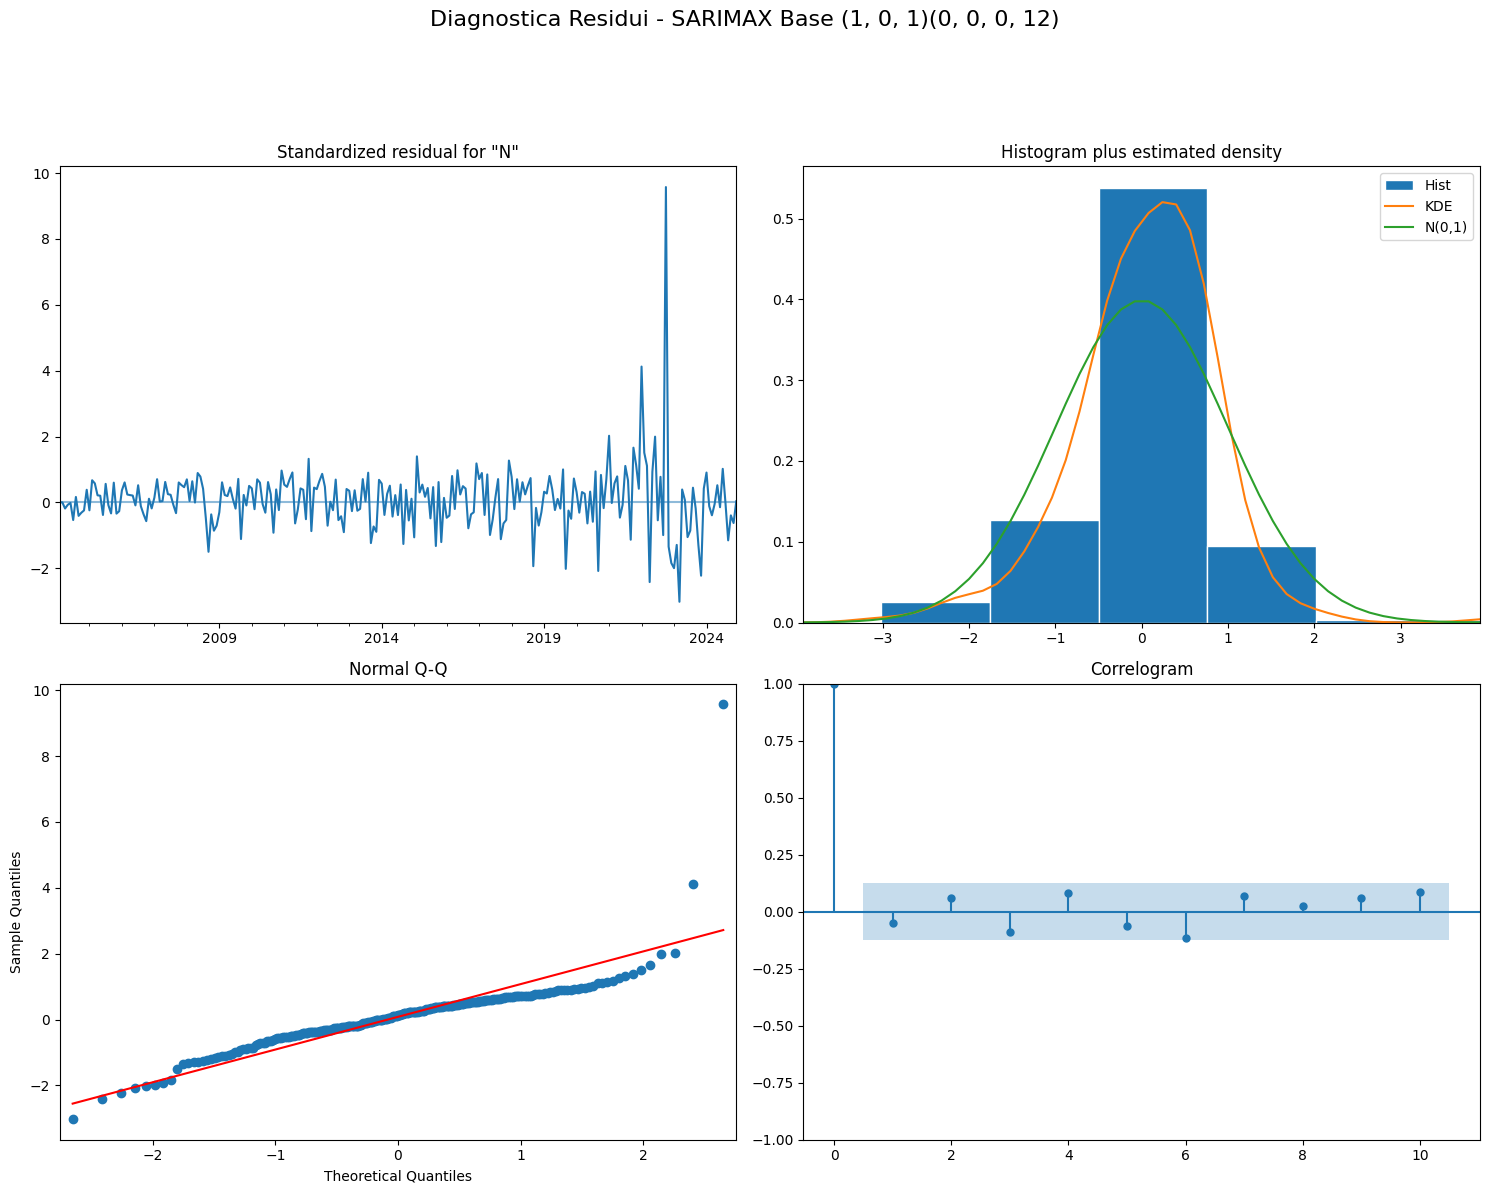


--- Test Statistici sui Residui ---
Test di Ljung-Box (lag=10): p-value = 0.1838 (H0: no autocorrelazione)
  -> Residui probabilmente non autocorrelati.
Test di Jarque-Bera (normalità): p-value = 0.0000 (H0: normalità)
  -> ATTENZIONE: Residui potrebbero non essere normali.
--- Fine Diagnostica ---
Miglior modello SARIMAX salvato in: /Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/miglior_modello_sarimax.pkl

>>> SCRIPT FASE 6 (Selezione Automatica v3) COMPLETATO <<<


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import pickle # Per salvare il modello

# Ignoro i warning di convergenza durante la grid search e altri warning comuni
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIGURAZIONE ---
# Path al file di input (output della Fase 2 - serie stazionarie)
PATH_INPUT_DIR_FASE2 = "/Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2"
FILE_SERIE_STAZIONARIE_IN = os.path.join(PATH_INPUT_DIR_FASE2, "indici_gt_nic_stazionari_fase2.csv")

# Nome della colonna dell'inflazione stazionaria (differenziata)
COL_INFLAZIONE_STAZ = 'NIC_destag_ISTAT_diff1'

# Data della rottura strutturale per la dummy
BREAKPOINT_DATE_DUMMY = '2022-03-01'

# Parametri per l'analisi ACF/PACF iniziale e diagnostica residui
MAX_LAGS_ACF_PACF = 36
SEASONAL_PERIOD = 12

# Path per salvare output di questa fase
PATH_OUTPUT_FASE6 = "/Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli"
FILE_GRAFICO_ACFPACF_INFL = os.path.join(PATH_OUTPUT_FASE6, "acf_pacf_inflazione_staz.png")
FILE_RISULTATI_GRID_SEARCH = os.path.join(PATH_OUTPUT_FASE6, "grid_search_sarimax_results.csv")
FILE_GRAFICO_DIAGNOSTICA_BEST = os.path.join(PATH_OUTPUT_FASE6, "diagnostica_miglior_modello.png")
FILE_MODELLO_PICKLE = os.path.join(PATH_OUTPUT_FASE6, "miglior_modello_sarimax.pkl")

# Parametri per la Grid Search Automatica
MAX_P_NON_STAG = 2  # Ordine AR massimo non stagionale
MAX_Q_NON_STAG = 2  # Ordine MA massimo non stagionale
MAX_P_STAG = 1      # Ordine AR massimo stagionale
MAX_Q_STAG = 1      # Ordine MA massimo stagionale
# d e D sono 0 perché la serie è già stata differenziata e destagionalizzata
ORDER_d_NON_STAG = 0
ORDER_D_STAG = 0
CRITERION_SELEZIONE = 'aic' # 'aic' o 'bic'

# --- FUNZIONI AUSILIARIE ---
def carica_dati_stazionari(path_file):
    print(f"--- Caricamento Serie Stazionarie da: {path_file} ---")
    try:
        df = pd.read_csv(path_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        print(f"Serie caricate con successo. Shape: {df.shape}")
        return df
    except Exception as e: print(f"ERRORE caricamento: {e}"); return None

# --- Funzione per creare una dummy di intervento ---
def crea_dummy_intervento(serie_index, breakpoint_date_str, dummy_name="dummy_intervento"):
    breakpoint_ts = pd.Timestamp(breakpoint_date_str)
    dummy = pd.Series(0, index=serie_index, name=dummy_name)
    dummy[serie_index >= breakpoint_ts] = 1
    return dummy

# --- Funzione per la ricerca automatica degli ordini SARIMA ---
def auto_sarima_grid_search(y_series, exog_series=None,
                           max_p=2, max_q=2, max_P=1, max_Q=1,
                           d=0, D=0, s=12,
                           criterion='aic', verbose=True):
    print(f"\n=== INIZIO RICERCA AUTOMATICA ORDINI SARIMA (Criterio: {criterion.upper()}) ===")
    print(f"Range ordini: p<={max_p}, q<={max_q}, P<={max_P}, Q<={max_Q} | d={d}, D={D}, s={s}")
    p_rng, q_rng, P_rng, Q_rng = range(max_p+1), range(max_q+1), range(max_P+1), range(max_Q+1)
    all_orders = list(itertools.product(p_rng, q_rng, P_rng, Q_rng))
    print(f"Numero totale di combinazioni da testare: {len(all_orders)}")
    
    results_list = []
    for i, (p, q, P, Q) in enumerate(all_orders):
        order = (p, d, q); seasonal_order = (P, D, Q, s)
        if verbose and (i % 10 == 0 or i == len(all_orders) - 1) :
            print(f"Test modello {i+1}/{len(all_orders)}: SARIMA{order}{seasonal_order}...")
        try:
            model = sm.tsa.SARIMAX(y_series, exog=exog_series, order=order, seasonal_order=seasonal_order,
                                 enforce_stationarity=False, enforce_invertibility=False,
                                 initialization='approximate_diffuse') # Può aiutare la convergenza
            
            # Aumento maxiter e provo diversi metodi di ottimizzazione se necessario
            fitted_model = model.fit(disp=False, maxiter=200, method='lbfgs') # 'powell', 'cg', 'ncg'

            current_criterion_val = getattr(fitted_model, criterion.lower()) # fitted_model.aic o fitted_model.bic
            
            # Test di Ljung-Box sui residui
            lb_lags = min(10, len(y_series)//5) if len(y_series)//5 > 0 else 1
            lb_df = acorr_ljungbox(fitted_model.resid, lags=[lb_lags], return_df=True)
            lb_pvalue = lb_df['lb_pvalue'].iloc[0] if not lb_df.empty and 'lb_pvalue' in lb_df.columns else np.nan
            
            results_list.append({
                'order': order, 'seasonal_order': seasonal_order,
                'AIC': fitted_model.aic, 'BIC': fitted_model.bic,
                'LogLikelihood': fitted_model.llf, 'LjungBox_pvalue': lb_pvalue,
                'Converged': fitted_model.mle_retvals.get('converged', True)
            })

        except Exception as e:
            results_list.append({'order': order, 'seasonal_order': seasonal_order,
                               'AIC': np.nan, 'BIC': np.nan, 'LogLikelihood': np.nan,
                               'LjungBox_pvalue': np.nan, 'Converged': False, 'Error': str(e)[:50]})
            
    results_df = pd.DataFrame(results_list)
    valid_results_df = results_df[results_df['Converged'] == True].copy()
    if valid_results_df.empty:
        print("ERRORE: Nessun modello SARIMAX è convergito."); return None, None, float('inf'), results_df
    
    # Seleziono il miglior modello in base al criterio scelto
    valid_results_df = valid_results_df.sort_values(by=[criterion.upper(), 'LjungBox_pvalue'], ascending=[True, False])
    best_model_row = valid_results_df.iloc[0]
    final_best_order = best_model_row['order']
    final_best_seasonal_order = best_model_row['seasonal_order']
    final_best_criterion_val = best_model_row[criterion.upper()]
    print(f"\n=== MIGLIOR MODELLO TROVATO (secondo {criterion.upper()} e Ljung-Box) ===")
    print(f"Ordini: SARIMA{final_best_order}{final_best_seasonal_order}")
    print(f"{criterion.upper()}: {final_best_criterion_val:.3f}, BIC: {best_model_row['BIC']:.3f}, LogLik: {best_model_row['LogLikelihood']:.3f}")
    print(f"Ljung-Box p-value (residui): {best_model_row['LjungBox_pvalue']:.3f}")
    print("=== FINE RICERCA AUTOMATICA ORDINI SARIMA ===\n")
    return final_best_order, final_best_seasonal_order, final_best_criterion_val, results_df

# --- Funzione per la diagnostica del modello SARIMAX ---
def plot_model_diagnostics_v2(fitted_model, model_name="Modello", path_output_grafici=None, save_filename="diagnostica_modello.png"):
    """
    Visualizza la diagnostica standard per un modello SARIMAX fittato.
    Versione corretta per Jarque-Bera da scipy.stats.
    """
    print(f"\n--- Diagnostica Grafica e Test Residui per: {model_name} ---")
    residuals = fitted_model.resid
    try:
        fig = fitted_model.plot_diagnostics(figsize=(15, 12)) # Usa il plot di diagnostica integrato
        fig.suptitle(f"Diagnostica Residui - {model_name}", fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Aggiusto rect per il suptitle
        if path_output_grafici:
            if not os.path.exists(path_output_grafici): os.makedirs(path_output_grafici)
            full_save_path = os.path.join(path_output_grafici, save_filename)
            plt.savefig(full_save_path)
            print(f"Grafico diagnostica standard salvato in: {full_save_path}")
        plt.show()
    
    except Exception as e:
        print(f"Errore durante plot_diagnostics integrato: {e}. Procedo con plot manuali.")
        
        # Fallback a plot manuali se plot_diagnostics fallisce (raro ma possibile)
        fig_manual, axes_manual = plt.subplots(2, 2, figsize=(15, 10))
        residuals.plot(ax=axes_manual[0,0], title='Residui nel Tempo')
        axes_manual[0,0].grid(True, alpha=0.3)
        sm.qqplot(residuals, line='s', ax=axes_manual[0,1])
        axes_manual[0,1].set_title('Q-Q Plot (Normalità)')
        axes_manual[0,1].grid(True, alpha=0.3)
        plot_acf(residuals, lags=min(24, len(residuals)//4 -1), ax=axes_manual[1,0], title='ACF Residui')
        axes_manual[1,0].grid(True, alpha=0.3)
        residuals.plot(kind='hist', bins=30, density=True, ax=axes_manual[1,1], title="Istogramma Residui")
        residuals.plot(kind='kde', ax=axes_manual[1,1])
        axes_manual[1,1].grid(True, alpha=0.3)
        plt.tight_layout()
        
        if path_output_grafici: # Salvo anche il grafico manuale se il primo fallisce
             manual_filename = "manual_" + save_filename
             full_manual_save_path = os.path.join(path_output_grafici, manual_filename)
             plt.savefig(full_manual_save_path)
             print(f"Grafico diagnostica manuale salvato in: {full_manual_save_path}")
        plt.show()


    print("\n--- Test Statistici sui Residui ---")
    # Ljung-Box
    lb_lags = min(10, len(residuals)//5) if len(residuals)//5 > 0 else 1
    if lb_lags > 0 : # Assicura che ci siano lag da testare
        lb_df = acorr_ljungbox(residuals, lags=[lb_lags], return_df=True)
        lb_pvalue = lb_df['lb_pvalue'].iloc[0] if not lb_df.empty else np.nan
        print(f"Test di Ljung-Box (lag={lb_lags}): p-value = {lb_pvalue:.4f} (H0: no autocorrelazione)")
        if lb_pvalue > 0.05: print("  -> Residui probabilmente non autocorrelati.")
        else: print("  -> ATTENZIONE: Residui potrebbero essere autocorrelati.")
    else:
        print("Test di Ljung-Box non eseguito (serie residui troppo corta).")

    # Jarque-Bera (da scipy.stats, restituisce 2 valori)
    if len(residuals) > 2:
        jb_stat, jb_pvalue = jarque_bera(residuals)
        print(f"Test di Jarque-Bera (normalità): p-value = {jb_pvalue:.4f} (H0: normalità)")
        if jb_pvalue > 0.05: print("  -> Residui probabilmente normali.")
        else: print("  -> ATTENZIONE: Residui potrebbero non essere normali.")
    else:
        print("Test di Jarque-Bera non eseguito (serie residui troppo corta).")
    print("--- Fine Diagnostica ---")

# --- ESECUZIONE SCRIPT FASE 6 ---
if __name__ == "__main__":
    print(">>> INIZIO SCRIPT FASE 6: Costruzione Modello Base SARIMAX (Selezione Automatica v3) <<<\n")
    os.makedirs(PATH_OUTPUT_FASE6, exist_ok=True)
    print(f"Directory di output: '{PATH_OUTPUT_FASE6}'\n")

    # Carico i dati stazionari
    df_serie_stazionarie = carica_dati_stazionari(FILE_SERIE_STAZIONARIE_IN)
    if df_serie_stazionarie is None or COL_INFLAZIONE_STAZ not in df_serie_stazionarie.columns:
        print(f"ERRORE CRITICO: Dati non caricati o colonna '{COL_INFLAZIONE_STAZ}' mancante."); exit()

    # Verifico che la serie di inflazione stazionaria non sia vuota
    y_inflazione = df_serie_stazionarie[COL_INFLAZIONE_STAZ].dropna()
    if y_inflazione.empty: print(f"ERRORE: Serie '{COL_INFLAZIONE_STAZ}' vuota."); exit()

    dummy_mar2022 = crea_dummy_intervento(y_inflazione.index, BREAKPOINT_DATE_DUMMY)
    dummy_mar2022_aligned = dummy_mar2022.reindex(y_inflazione.index, fill_value=0).astype(float)

    print(f"--- Analisi ACF/PACF per: {COL_INFLAZIONE_STAZ} (per guida visuale) ---")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(y_inflazione, lags=MAX_LAGS_ACF_PACF, ax=axes[0], title=f"ACF - {COL_INFLAZIONE_STAZ}")
    axes[0].grid(True, alpha=0.5)
    plot_pacf(y_inflazione, lags=MAX_LAGS_ACF_PACF, ax=axes[1], title=f"PACF - {COL_INFLAZIONE_STAZ}", method='ols')
    axes[1].grid(True, alpha=0.5)
    plt.tight_layout(); plt.savefig(FILE_GRAFICO_ACFPACF_INFL); plt.show()

    best_order, best_seasonal_order, best_criterion, all_search_results = auto_sarima_grid_search(
        y_inflazione, exog_series=dummy_mar2022_aligned,
        max_p=MAX_P_NON_STAG, max_q=MAX_Q_NON_STAG, max_P=MAX_P_STAG, max_Q=MAX_Q_STAG,
        d=ORDER_d_NON_STAG, D=ORDER_D_STAG, s=SEASONAL_PERIOD, criterion=CRITERION_SELEZIONE)
    
    if all_search_results is not None:
        all_search_results.to_csv(FILE_RISULTATI_GRID_SEARCH, index=False)
        print(f"Risultati grid search salvati in: {FILE_RISULTATI_GRID_SEARCH}")

    if best_order and best_seasonal_order:
        print(f"\n--- Stima e Diagnostica del Miglior Modello SARIMA{best_order}{best_seasonal_order} ---")
        try:
            miglior_modello = sm.tsa.SARIMAX(y_inflazione, exog=dummy_mar2022_aligned,
                                           order=best_order, seasonal_order=best_seasonal_order,
                                           enforce_stationarity=False, enforce_invertibility=False,
                                           initialization='approximate_diffuse')
            risultati_miglior_modello = miglior_modello.fit(disp=False, maxiter=200)
            print("\n--- Sommario Miglior Modello SARIMAX ---"); print(risultati_miglior_modello.summary())
            plot_model_diagnostics_v2(risultati_miglior_modello,
                                   model_name=f"SARIMAX Base {best_order}{best_seasonal_order}",
                                   path_output_grafici=PATH_OUTPUT_FASE6,
                                   save_filename="diagnostica_miglior_modello.png")
            with open(FILE_MODELLO_PICKLE, 'wb') as pkl_file: pickle.dump(risultati_miglior_modello, pkl_file)
            print(f"Miglior modello SARIMAX salvato in: {FILE_MODELLO_PICKLE}")
        except Exception as e: print(f"ERRORE stima/diagnostica miglior modello: {e}")
    else: print("\nNessun modello ottimale trovato. Impossibile procedere con stima finale.")
    print("\n>>> SCRIPT FASE 6 (Selezione Automatica v3) COMPLETATO <<<")
